In [2]:
import numpy as np
import numba
import random
import matplotlib.pyplot as plt
import scipy.integrate

import seaborn as sns
sns.set(font_scale = 1.5, rc={"lines.linewidth":2})

# Midterm 2

# Problem 1 - Nullcines (6 pts.)

Below we consider the system of equations for two genes $a$ and $b$ which activate each other:

\begin{aligned}
&\dot{a}=\frac{\beta_a}{\left(\frac{k_b}{b}\right)^n+1}-\gamma_a a \\[1em]
&\dot{b}=\frac{\beta_b}{\left(\frac{k_a}{a}\right)^n+1}-\gamma_b b
\end{aligned}

## Part a

Explain why plotting the nullclines and finding where they cross corresponds to the fixed points of the system.

## Part b

Using the parameters and values provided below, plot the nulleclines for when $n=1$ and when $n=2$.

In [3]:
# parameters
gamma_a = gamma_b = 4 # per min
beta_a = beta_b = 10 # per min 
k_a = k_b = 1 # copy number

# values of a and b to plot over
a = np.linspace(-0.1, 3, 100)
b = np.linspace(-0.1, 3, 100)

## part c

How did the number of fixed points change as you changed the value of $n$?

## part d

Which bifurcation diagram below (1 or 2) better describes the behavior of the fixed points you've seen? Why? (Note I only plot for $n > 1$ since that is the lowest value that is biologically meaningful here.)

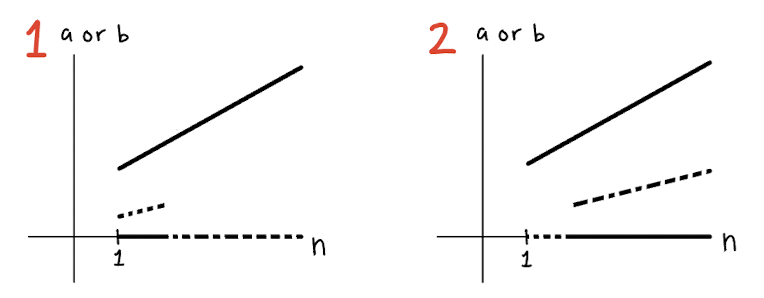


# Problem 2 - Gillespie simulation for gene expression modified (7 pts.)

We previously used the following set of differential equations to keep track of the number of mRNAs and protein.

$$ \frac{\mathrm{d}m}{\mathrm{d}t} = \beta_m - \gamma_m m,$$

$$ \frac{\mathrm{d}p}{\mathrm{d}t} = \beta_p m - \gamma_p p$$

And using a Gillespie simulation approach, we specified the propensities as:

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{propensity, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\[0.3em]
m \rightarrow m-1, \;\;\;\; & \gamma_m m\\[0.3em]
p \rightarrow p+1, \;\;\;\; & \beta_p m \\[0.3em]
p \rightarrow p-1, \;\;\;\; & \gamma_p p.
\end{array}
\end{align}

Let's change the differential equations slightly, as shown below. **We will use this version of the equations throughout this question.**

$$ \frac{\mathrm{d}m}{\mathrm{d}t} = \beta_m \frac{p}{1+p}  - \gamma_m m,$$

$$ \frac{\mathrm{d}p}{\mathrm{d}t} = \beta_p m - \gamma_p p$$

## Part a

Explain the biological meaning of the changes made to the system of equations. e.g. How does the number of mRNAs influence the production of protein or how does the number of proteins influence the production of mRNA? 

## Part b

Which of the four reactions' propensities should change as a result of the changes in the differential equations?

## Part c

Modify the Gillespie simulation code below to change the reaction propensities accordingly. 

In [4]:
# specifying the parameters
beta_m = beta_p = 10 # per min
gamma_m = gamma_p = 1 # per min, per transcript

# how long we want run simulation for
total_time = 20 # mins

def gillespie():
    
    # initializing the number of mRNAs and the time
    m = [1]
    p = [1]
    t = [0]

    while t[-1] < total_time:

        # specify the propensities for the possible state change
        m_production_rate = beta_m 
        m_degradation_rate = m[-1] * gamma_m
        p_production_rate = beta_p * m[-1]
        p_degradation_rate = p[-1] * gamma_p

        # add up all the propensities
        total_prop = m_production_rate + m_degradation_rate + p_production_rate + p_degradation_rate

        # determine how much time elapses before "something+ happens
        time_elapsed = np.random.exponential(1/total_prop)

        # update time array 
        t.append(t[-1] + time_elapsed)

        # randomly choose which event happens
        event = random.choices(["m production", "m degradation", "p production", "p degradation"], 
                               weights=(m_production_rate, m_degradation_rate,
                                        p_production_rate, p_degradation_rate,))[0]

        # update mRNA list based on which event happend
        if event == "m production":
            m.append(m[-1]+1)
            p.append(p[-1])

        if event == "m degradation":
            m.append(m[-1]-1)
            p.append(p[-1])

        if event == "p production":
            p.append(p[-1]+1)
            m.append(m[-1])

        if event == "p degradation":
            p.append(p[-1]-1)
            m.append(m[-1])
            
    return t, m, p

Below I plot the results of the Gillespie simulation run 10 times so you can see the "typical behavior".

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True)

for i in range(10):
    t, m, p = gillespie()
    
    ax[0].plot(t, m, color="k", alpha=0.1)
    ax[1].plot(t, p, color="k", alpha=0.1)
    
ax[0].set_xlabel("time (mins)")
ax[0].set_ylabel("number of mRNAs")

ax[1].set_xlabel("time (mins)")
ax[1].set_ylabel("number of protiens");

## Part d

From your plotted results, what are the steady state (i.e. fixed point) values for the mRNA and protein? What impact did the change in these differential equation have on the steady state values?

# Problem 3 - Diffusion with flow via Master Equation (7 pts.)

Let's say we want to model diffusion in the presence of some flow. As a simplification, we can model this as a given particle is **twice as likely to "jump" to the left as it is to "jump" to the right** at each time point. There will still be randomness in how the particles move, but there is an overall preference to move to the left given the flow. 

Let's specify all the parameters and initialize all the probability to be in the center, as shown below:

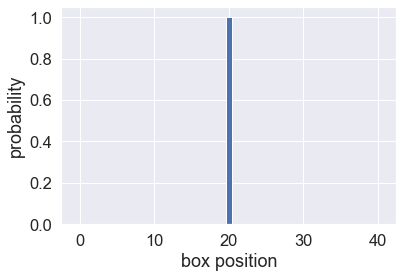

In [5]:
# number of boxes
n_boxes = 41

# time increment (Delta t) in seconds
dt = 0.1

# number of steps
n_steps = 100

# hopping rate constant (k) in sec^-1
k = 1

# initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# find the middle box
n_center = int(n_boxes / 2)

# set the middle box to have probability 1 at the initial time step 
p[n_center, 0] = 1

# show initial proability
plt.bar(np.arange(n_boxes), p[:,0])
plt.xlabel("box position")
plt.ylabel("probability");

## part a

Before coding anything, explain what you expect to see happen to the probability distribution over time under this model of diffusion with flow.


## part b

Modify the code for the numerical integration to include the modification that particles should be twice as likely to jump to the left as to the right.

There are a total of **four** terms that should be modified below. Make those changes.

In [ ]:
# loop through the number of steps
for t in range(1, n_steps):
    
    # update probability array in the interior region
    for b in range(1,n_boxes-1):
        p[b,t] = p[b,t-1] + k*dt*p[b-1,t-1] + k*dt*p[b+1,t-1] - 2*k*dt*p[b,t-1]

    # update probability array for the left-most box
    p[0,t] = p[0,t-1] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # update probability array for the right-most box
    p[-1,t] = p[-1,t-1] + k*dt*p[-2,t-1] - k*dt*p[-1,t-1]

Now I plot the results at time 0, 49, and 99. **Make sure to run this cell again to see the effect of your changes!**

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].bar(np.arange(n_boxes), p[:,0])
ax[0].set_xlabel("box position")
ax[0].set_ylabel("probability");

ax[1].bar(np.arange(n_boxes), p[:,49])
ax[1].set_xlabel("box position")

ax[2].bar(np.arange(n_boxes), p[:,99])
ax[2].set_xlabel("box position");

## part c

Do the plotted results match what you expected? Why or why not? **You can still answer this even if you didn't do part b correctly!**